# Reproducing HECKTOR 2022 predictions

In this notebook, we show how we produced the predictions that we submitted for the [HECKTOR 2022 challenge](https://hecktor.grand-challenge.org/) outcome prediction task (Task 2). This model achieved 0.68152 of C-index, ranking first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.util import Surv
from scipy.stats import spearmanr, pearsonr

from icare.survival import BaggedIcareSurvival
from icare.visualisation import plot_avg_sign

We load the CSV built from the radiomic features extraction step. The code of this step will be published soon. In the mean time please refere to the paper:

> Rebaud, L.\*, Escobar, T.\*, Khalid, F., Girum, K., Buvat, I.: Head and Neck Tumor and Lymph Node 
Segmentation and Outcome Prediction from 18F-FDG PET/CT Images: Simplicity is All You Need. 
In: Lecture Notes in Computer Science (LNCS) Challenges (under review)


Note that the number of patients in the train CSV is not 488 but 486. It is due to our segmentation step predicting only background without lesion for 2 patients.

In [2]:
df_train = pd.read_csv('../data/df_train.csv', index_col='PatientID')
df_test = pd.read_csv('../data/df_test.csv', index_col='PatientID')
df_train.shape, df_test.shape

((486, 2433), (339, 2430))

We list all the features in the CSV and determine their respective group.

In [3]:
features = list(set(df_train.columns.tolist()) - set(['Relapse', 'RFS', 'Task 1', 'Task 2', 'CenterID']))
features = [x for x in features if 'lesions_merged' not in x and 'lymphnodes_merged' not in x]
extra_features = ['Gender',
                  'Age',
                  'Weight',
                  'Tobacco',
                  'Alcohol',
                  'Performance status',
                  'HPV status (0=-, 1=+)',
                  'Surgery',
                  'Chemotherapy',
                  'nb_lesions',
                  'nb_lymphnodes',
                  'whole_body_scan']

features_groups = np.unique([x.split('_shape_')[0].split('_PT_')[0].split('_CT_')[0] for x in features])
features_groups = list(set(features_groups) - set(extra_features))
features_groups = [x + '_' for x in features_groups]
features_groups.append('extra_features')
len(features_groups), features_groups

(14,
 ['everything_mergeddilat1mm_',
  'everything_merged2.5_',
  'everything_mergedshell4mm_',
  'everything_mergedshell8mm_',
  'everything_merged_',
  'everything_mergeddilat4mm_',
  'everything_mergedBBox_',
  'everything_mergeddilat2mm_',
  'everything_merged40%_',
  'everything_mergeddilat8mm_',
  'everything_mergedshell2mm_',
  'everything_merged4_',
  'everything_mergeddilat16mm_',
  'extra_features'])

We then encode these groups with index values.

In [4]:
y_train = Surv.from_arrays(event=df_train['Relapse'].values,
                           time=df_train['RFS'].values)
X_train, X_test = df_train[features], df_test[features]

In [5]:
features_groups_id = []
for f in X_train.columns:
    if f in extra_features:
        features_groups_id.append(features_groups.index('extra_features'))
    else:
        group = f.split('_shape_')[0].split('_PT_')[0].split('_CT_')[0] + '_'
        features_groups_id.append(features_groups.index(group))

We format the CSV to get compatible X (the input of the model as a DataFrame) for the train and test CSV.

We also format the target values RFS and Relapse as a sksurv structured array so the ICARE model can use it.

Here are the results of the random search for hyperparameters tuning. 1000 random sets were evaluated with a 200-folds Monte Carlo cross-validation with a test size of 50%. The 5 best sets were selected to increase randomness and reduce the risk of overfitting compared to picking only the best set. Each estimator in the bagged model model will randomly pick a set in this list.

In [6]:
hyperparameters_sets = [
 {'rho': 0.66,
  'cmin': 0.53,
  'max_features': 0.00823045267489712,
  'mandatory_features': extra_features,
  'sign_method': 'harrell',
  'features_groups_to_use': [2, 4, 8, 10]},
 {'rho': 0.72,
  'cmin': 0.59,
  'max_features': 0.009465020576131687,
  'mandatory_features': extra_features,
  'sign_method': 'harrell',
  'features_groups_to_use': [3, 4, 10, 11, 12]},
 {'rho': 0.87,
  'cmin': 0.55,
  'max_features': 0.06131687242798354,
  'mandatory_features': extra_features,
  'sign_method': 'harrell',
  'features_groups_to_use': [1, 3, 4, 10, 11, 12]},
 {'rho': 0.57,
  'cmin': 0.51,
  'max_features': 0.005761316872427984,
  'mandatory_features': extra_features,
  'sign_method': 'harrell',
  'features_groups_to_use': [0, 2, 5, 6, 9, 11, 12]},
 {'rho': 0.71,
  'cmin': 0.57,
  'max_features': 0.16131687242798354,
  'mandatory_features': extra_features,
  'sign_method': 'harrell',
  'features_groups_to_use': [4, 8, 12]}
]

The bagged ICARE model is then trained with the whole train set and makes predictions on the test set. We observed that the higher the number of estimators, the better the predictions. Thus, the 100k estimators in this model to ensure we reached a plateau. For a reasonable computational cost, this can be decreased to 1000 or less.

In [7]:
model = BaggedIcareSurvival(n_estimators=1000,
                            parameters_sets=hyperparameters_sets,
                            aggregation_method='median',
                            n_jobs=-1)
model.fit(X_train,y_train, feature_groups=features_groups_id)
test_pred = model.predict(X_test)

To test for reproducibility, we load the CSV we submitted for the HECKTOR 2022 challenge and we check that the predictions made here are concordant with it.

In [8]:
pred_submitted = pd.read_csv('../data/LITO_Task2_louis3.csv', index_col='PatientID')

In [9]:
spearmanr(pred_submitted['Prediction'], test_pred)

SpearmanrResult(correlation=0.9866930130694996, pvalue=6.110186525692019e-268)

In [10]:
pearsonr(pred_submitted['Prediction'], test_pred)

PearsonRResult(statistic=0.9833556451652524, pvalue=1.0978243625561884e-251)

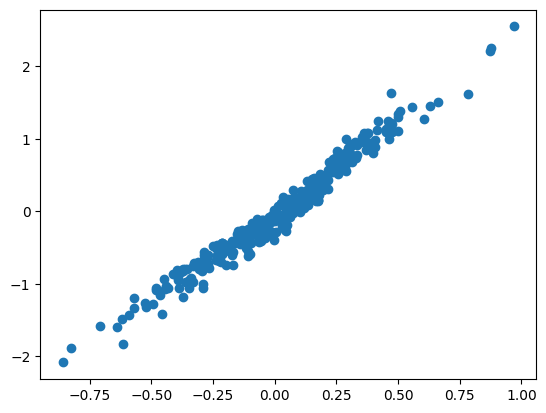

In [11]:
plt.scatter(pred_submitted['Prediction'], test_pred)
plt.show()

This last cell shows how to use the ICARE package to plot the average signs in the trained model to interpret it. We specify which features we want to display so the plot is lisible.

A positive sign means that the feature is anti-concordant with the target value (e.g. decreases RFS when value increases, meaning a higher risk), and the other way around for a negative sign. A value close to zero mean that the feature sign was unstable. This can be due to a low predictive power.

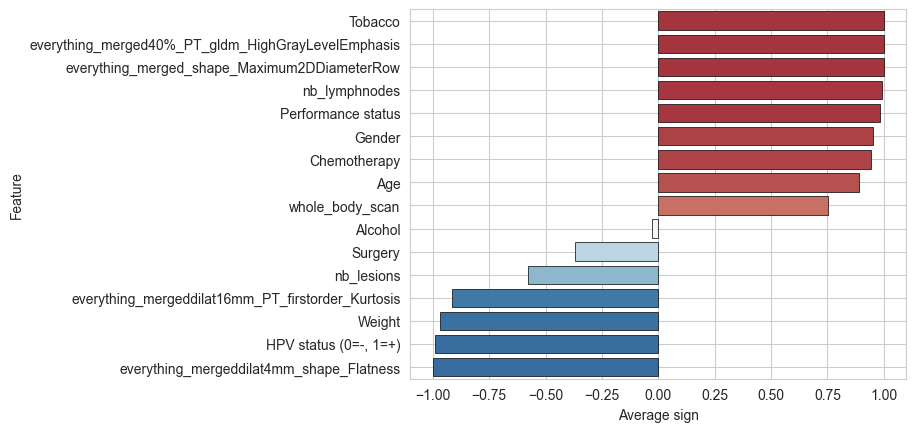

In [12]:
rad_extra = [
'everything_merged_shape_Maximum2DDiameterRow',
'everything_mergedBBox_CT_firstorder_90Percentile',
'everything_merged40%_PT_gldm_HighGrayLevelEmphasis',
'everything_mergedshell4mm_PT_gldm_LargeDependenceLowGrayLevelEmphasis',
'everything_mergeddilat16mm_PT_firstorder_Kurtosis',
'everything_mergeddilat4mm_shape_Flatness',
]


plot_avg_sign(model, features=extra_features+rad_extra)
plt.show()